In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from math import log, e, sqrt
from scipy.stats import entropy
from scipy.stats import norm

In [2]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')

In [3]:
DATA_PATH = '/Users/francis/workspace/news-entropy/data/guardian_politics/content/'
FILENAME = 'data_attributes2'

In [4]:
df = pd.read_csv(DATA_PATH + FILENAME + '.csv')
df.rename(columns = {'Unnamed: 0':'link'}, inplace = True)
df = df.sort_values('snapshot').reset_index(drop=True)

In [5]:
df.shape

(7249, 11)

In [6]:
df.head()

link    neg    neu    pos  \
0  http://www.theguardian.com/politics/2013/aug/3...  0.139  0.774  0.087   
1  http://www.theguardian.com/world/2013/aug/29/s...  0.137  0.776  0.087   
2  http://www.theguardian.com/commentisfree/2013/...  0.176  0.705  0.120   
3  http://www.theguardian.com/politics/2013/aug/2...  0.101  0.739  0.160   
4  http://www.theguardian.com/uk-news/2013/aug/29...  0.061  0.916  0.023   

   compound    FRE  difficult_word_count  sentence_count   DCR  \
0   -0.9982  51.72                   229              52  7.52   
1   -0.9983  24.31                   255              25  9.29   
2   -0.9971  60.48                   177              34  7.99   
3    0.9901  75.34                   128              33  7.58   
4   -0.9348   0.77                    49               4  9.99   

           readability  snapshot  
0  13th and 14th grade  20130830  
1  12th and 13th grade  20130830  
2  11th and 12th grade  20130830  
3  10th and 11th grade  20130830  
4  32nd and 33rd grade  20130830

In [14]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [8]:
def entropy_calc(df, col):
    vc= df[col].value_counts(normalize=True, sort=False)
    return -(vc * np.log(vc)/np.log(e)).sum()

In [9]:
def sliding_window_analysis(df, col, window_size=31):
    if(window_size % 2 == 0):
        logging.info('ERROR - Window size must be negative')
        return []
    time_array = []
    entropic_series = []
    days = df['snapshot'].sort_values().unique()
    max_iter = len(days) - window_size
    if max_iter < 1:
        logging.info('Window size too large, please rerun with a smaller value')
        return entropic_series
    
    for i in range(0, max_iter):
        df_window = df[df['snapshot'].isin(days[i:i+window_size])]
        entropic_series.append(entropy_calc(df=df_window, col=col))
        median_date = days[int(i+((window_size-1)/2))]
        time_array.append(median_date)
        
    return entropic_series, time_array

In [10]:
### Basic data prep

df = df[(df['pos'] != 0) & (df['neg'] != 0) & (df['neu'] != 0)]

2020-12-06 16:38:29 INFO     NumExpr defaulting to 4 threads.


In [70]:
min_date = 20150101
max_date = 20210101

sub_df = df[(df['snapshot'] > min_date) & (df['snapshot'] < max_date)]

s_pos, t_pos = sliding_window_analysis(df=sub_df, col='pos', window_size=31)
s_neg, t_neg = sliding_window_analysis(df=sub_df, col='neg', window_size=31)
s_neu, t_neu = sliding_window_analysis(df=sub_df, col='neu', window_size=31)

t_pos = pd.to_datetime(pd.Series(t_pos), format='%Y%m%d')
t_neg = pd.to_datetime(pd.Series(t_neg), format='%Y%m%d')
t_neu = pd.to_datetime(pd.Series(t_neu), format='%Y%m%d')

fig, axes = plt.subplots(2,2,figsize=(15,15))

axes[0,0].plot(t_pos, pd.Series(s_pos).rolling(window=7, min_periods=1).mean(), label = "Positivity") 
axes[0,0].plot(t_neg, pd.Series(s_neg).rolling(window=7, min_periods=1).mean(), label = "Negativity")
axes[0,0].plot(t_neu, pd.Series(s_neu).rolling(window=7, min_periods=1).mean(), label = "Neutrality")
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Entropy of sentiment')
axes[0,0].set_title(f'Rolling entropy change between {min_date} - {max_date}')
axes[0,0].legend()

n, bins, patches = axes[0,1].hist(df.sort_values(by='pos').reset_index(drop=True)['pos'], 100)
axes[0,1].set_xlabel('Positivity')
axes[0,1].set_ylabel('Probability density')
axes[0,1].set_title('Positivity Density Histogram')

n, bins, patches = axes[1,0].hist(df.sort_values(by='neg').reset_index(drop=True)['neg'], 100)
axes[1,0].set_xlabel('Negativity')
axes[1,0].set_ylabel('Probability density')
axes[1,0].set_title('Negativity Density Histogram')

n, bins, patches = axes[1,1].hist(df.sort_values(by='difficult_word_count').reset_index(drop=True)['neu'], 100)
axes[1,1].set_xlabel('Neutrality')
axes[1,1].set_ylabel('Probability density')
axes[1,1].set_title('Neutrality Density Histogram')


Text(0.5, 1.0, 'Neutrality Density Histogram')

In [90]:
rpos = pd.Series(s_pos).rolling(window=7, min_periods=1).mean()
rneg = pd.Series(s_neg).rolling(window=7, min_periods=1).mean()
rneu = pd.Series(s_neu).rolling(window=7, min_periods=1).mean()

corr = pd.DataFrame({'Positivity': rpos, 'Negativity': rneg, 'Neutrality': rneu}).corr()
corr.style.background_gradient(cmap='coolwarm')


In [91]:
def plot_pdf(min_date, max_date, df, col, symbol, color, axis_index=None, nbins=200):
    sub_df = df[(df['snapshot'] > min_date) & (df['snapshot'] < max_date)]
    col_to_plot = sub_df.sort_values(by=col).reset_index(drop=True)[col]
    (mu, sigma) = norm.fit(col_to_plot)
    min_label = str(min_date)[:4] + '-' + str(min_date)[4:6] + '-' + str(min_date)[6:]
    max_label = str(max_date)[:4] + '-' + str(max_date)[4:6] + '-' + str(max_date)[6:]
    if not axis_index:
        h = ax.hist(col_to_plot, nbins, color=color, density=True, alpha=0.35)
        y = norm.pdf(col_to_plot, mu, sigma)
        l = ax.plot(col_to_plot, y, symbol, linewidth=2, label=f'{min_label} - {max_label}')
    eles:
        h = ax[axis_index].hist(col_to_plot, nbins, color=color, density=True, alpha=0.35)
        y = norm.pdf(col_to_plot, mu, sigma)
        l = ax[axis_index].plot(col_to_plot, y, symbol, linewidth=2, label=f'{min_label} - {max_label}')

SyntaxError: invalid syntax (<ipython-input-91-fbe36ff3f92c>, line 11)

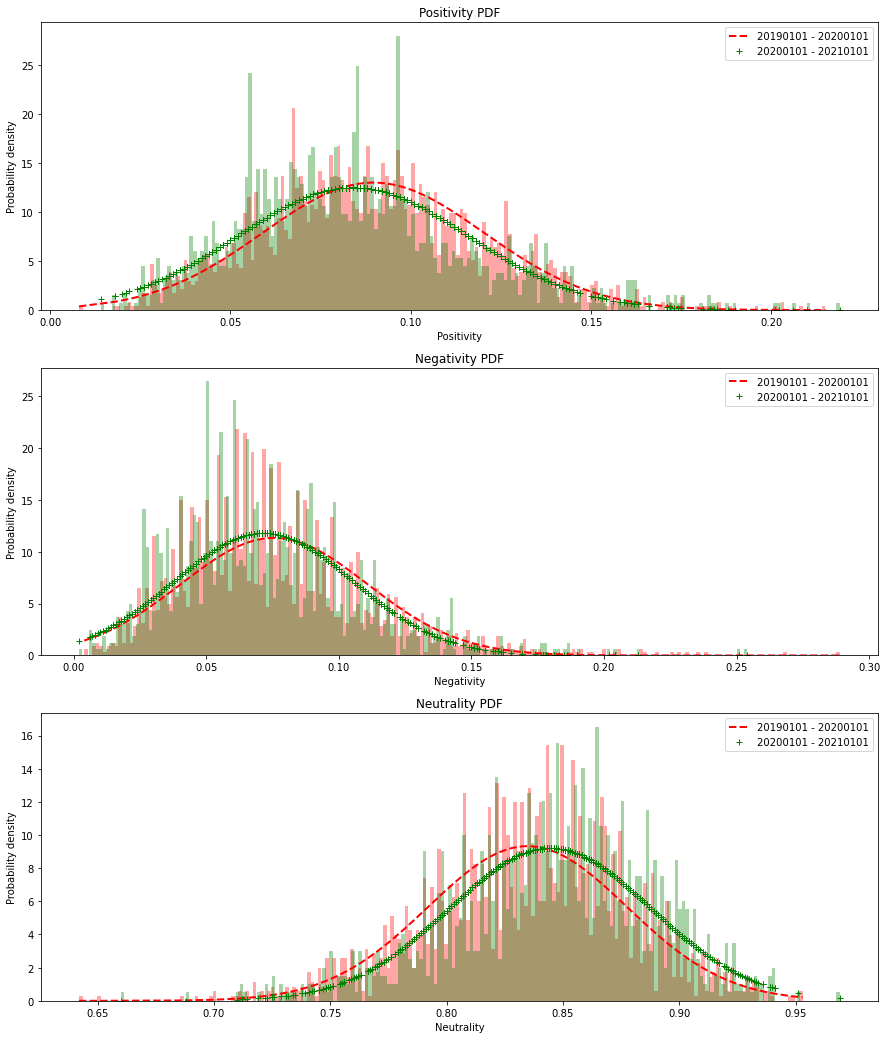

In [78]:
dates = [[20190101, 20200101], [20200101, 20210101]]

symbols = ['r--', 'g+', 'y^', 'bo', 'c*', 'm|']
colors = ['red', 'green', 'yellow', 'blue', 'cyan', 'maroon']

cols = [['pos', 'Positivity'], ['neg', 'Negativity'], ['neu', 'Neutrality']]

fig, ax = plt.subplots(len(cols), 1, figsize=(15, len(cols)*6))

for j in range(len(cols)):
    col = cols[j][0]
    name = cols[j][1]
    axis_index = j

    for i in range(len(dates)):
        min_date = dates[i][0]
        max_date = dates[i][1]
        symbol = symbols[i]
        color = colors[i]
        plot_pdf(min_date=min_date, max_date=max_date, df=df, col=col, symbol=symbol, 
                 axis_index=axis_index, color=color)

    ax[axis_index].set_xlabel(f'{name}')
    ax[axis_index].set_ylabel('Probability density')
    ax[axis_index].set_title(f'{name} PDF')
    ax[axis_index].legend()
    

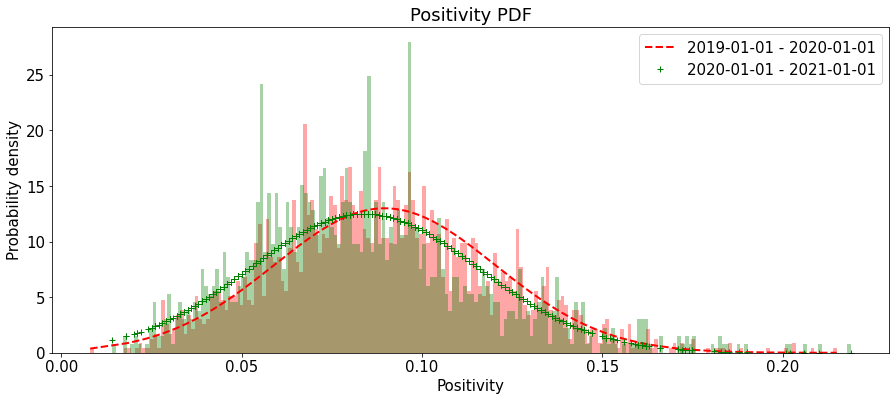

In [86]:
dates = [[20190101, 20200101], [20200101, 20210101]]


symbols = ['r--', 'g+', 'y^', 'bo', 'c*', 'm|']
cols = [['pos', 'Positivity'], ['neg', 'Negativity'], ['neu', 'Neutrality']]
cols = [['pos', 'Positivity'], ['neg', 'Negativity'], ['neu', 'Neutrality']]

plt.rc('font', size=15)  

for j in range(len(cols)):
    fig, ax = plt.subplots(figsize=(15, 6))

    col = cols[j][0]
    name = cols[j][1]

    for i in range(len(dates)):
        min_date = dates[i][0]
        max_date = dates[i][1]
        symbol = symbols[i]
        color = colors[i]
        plot_pdf(min_date=min_date, max_date=max_date, df=df, col=col, symbol=symbol, color=color)

    ax.set_xlabel(f'{name}')
    ax.set_ylabel('Probability density')
    ax.set_title(f'{name} PDF')
    ax.legend()
    plt.savefig(f'output/PDF-{name}.png')